<div>

> **Note**
>
> Code chunks run Python commands unless it starts with `%%bash`, in
> which case, those chunks run shell commands.

</div>

Celltype prediction can either be performed on indiviudal cells where
each cell gets a predicted celltype label, or on the level of clusters.
All methods are based on similarity to other datasets, single cell or
sorted bulk RNAseq, or uses known marker genes for each cell type.\
Ideally celltype predictions should be run on each sample separately and
not using the integrated data. In this case we will select one sample
from the Covid data, `ctrl_13` and predict celltype by cell on that
sample.\
Some methods will predict a celltype to each cell based on what it is
most similar to, even if that celltype is not included in the reference.
Other methods include an uncertainty so that cells with low similarity
scores will be unclassified.\
There are multiple different methods to predict celltypes, here we will
just cover a few of those.

Here we will use a reference PBMC dataset that we get from scanpy
datasets and classify celltypes based on two methods:

-   Using scanorama for integration just as in the integration lab, and
    then do label transfer based on closest neighbors.
-   Using ingest to project the data onto the reference data and
    transfer labels.
-   Using Celltypist to predicted with a pretrained pbmc model or with
    an own model based on the same reference data as the other methods.

First, lets load required libraries

In [1]:
#| label: libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import subprocess

warnings.simplefilter(action="ignore", category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 2
sc.settings.set_figure_params(dpi=80)

Let's read in the saved Covid-19 data object from the clustering step.

In [2]:
#| label: fetch-data
# download pre-computed data if missing or long compute
fetch_data = True

# url for source and intermediate data
path_data = "https://nextcloud.dc.scilifelab.se/public.php/webdav"
curl_upass = "zbC5fr2LbEZ9rSE:scRNAseq2025"

path_results = "data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

path_file = "data/covid/results/scanpy_covid_qc_dr_int_cl.h5ad"
if fetch_data and not os.path.exists(path_file):
    file_url = os.path.join(path_data, "covid/results_scanpy/scanpy_covid_qc_dr_int_cl.h5ad")
    subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])    

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 7332 × 3984
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'leiden', 'leiden_0.4', 'leiden_0.6', 'leiden_1.0', 'leiden_1.4', 'kmeans5', 'kmeans10', 'kmeans15', 'hclust_5', 'hclust_10', 'hclust_15'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'dendrogram_leiden_0.6', 'doublet_info_colors', 'hclust_10_colors', 'hclust_15_colors', 'hclust_5_colors', 'hvg', 'kmeans10_colors', 'kmeans15_colors', 'kmeans5_colors'

In [3]:
#| label: check-data
adata.uns['log1p']['base']=None
print(adata.shape)
# have only variable genes in X, use raw instead.
adata = adata.raw.to_adata()
print(adata.shape)

(7332, 3984)
(7332, 19468)


Subset one patient.

In [4]:
#| label: subset
adata = adata[adata.obs["sample"] == "ctrl_13",:]
print(adata.shape)

(1154, 19468)


In [5]:
#| label: count-cells
adata.obs["leiden_0.6"].value_counts()

leiden_0.6
1     276
3     207
0     200
6     124
2     123
4      68
5      49
7      32
8      23
9      18
10     18
11     16
Name: count, dtype: int64

Some clusters have very few cells from this individual, so any cluster
comparisons may be biased by this.

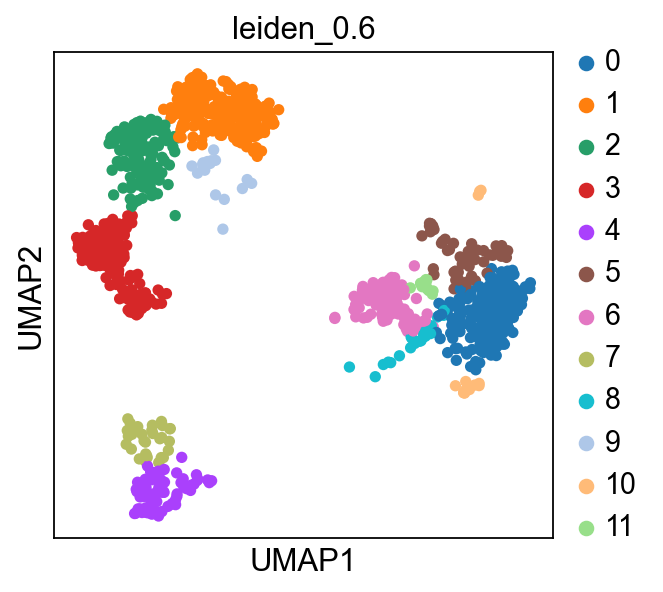

In [6]:
#| label: plot-umap
sc.pl.umap(
    adata, color=["leiden_0.6"], palette=sc.pl.palettes.default_20
)

## Reference data

Load the reference data from `scanpy.datasets`. It is the annotated and
processed pbmc3k dataset from 10x.

In [7]:
#| label: fetch-ref
adata_ref = sc.datasets.pbmc3k_processed()

In [8]:
adata_ref.obs['sample']='pbmc3k'

print(adata_ref.shape)
adata_ref.obs

(2638, 1838)


,n_genes,percent_mito,n_counts,louvain,sample
index,,,,,
AAACATACAACCAC-1,781,0.030178,2419.0,CD4 T cells,pbmc3k
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,pbmc3k
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T cells,pbmc3k
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,pbmc3k
AAACCGTGTATGCG-1,522,0.012245,980.0,NK cells,pbmc3k
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14+ Monocytes,pbmc3k
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B cells,pbmc3k
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,pbmc3k


As you can see, the celltype annotation is in the metadata column
`louvain`, so that is the column we will have to use for classification.

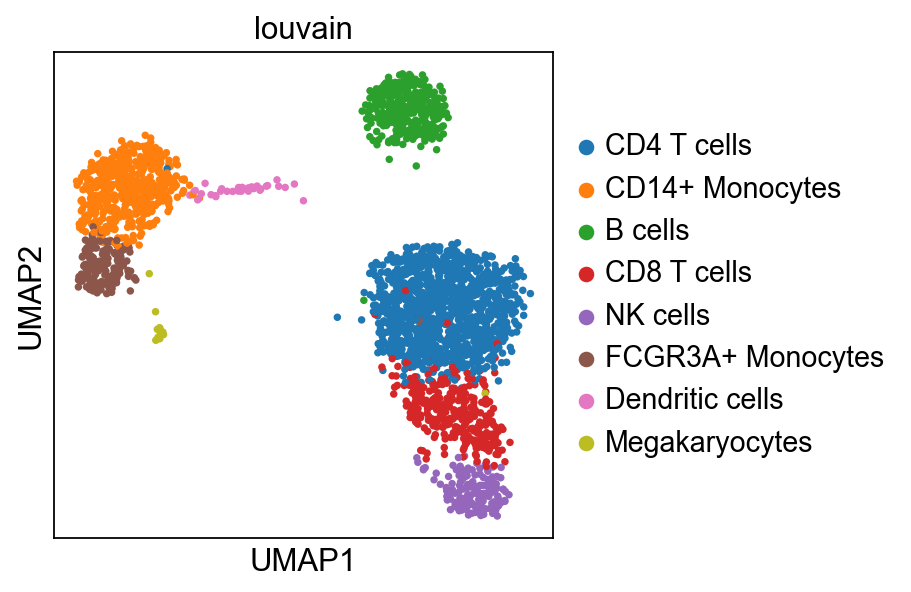

In [9]:
#| label: plot-ref
sc.pl.umap(adata_ref, color='louvain')

Make sure we have the same genes in both datset by taking the
intersection

In [10]:
#| label: intersect-genes
# before filtering genes, store the full matrix in raw.
adata.raw = adata
# also store the umap in a new slot as it will get overwritten
adata.obsm["X_umap_uncorr"] = adata.obsm["X_umap"]

print(adata_ref.shape[1])
print(adata.shape[1])
var_names = adata_ref.var_names.intersection(adata.var_names)
print(len(var_names))

adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

1838
19468
1676


First we need to rerun pca and umap with the same gene set for both
datasets.

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)
computing UMAP
    finished (0:00:02)


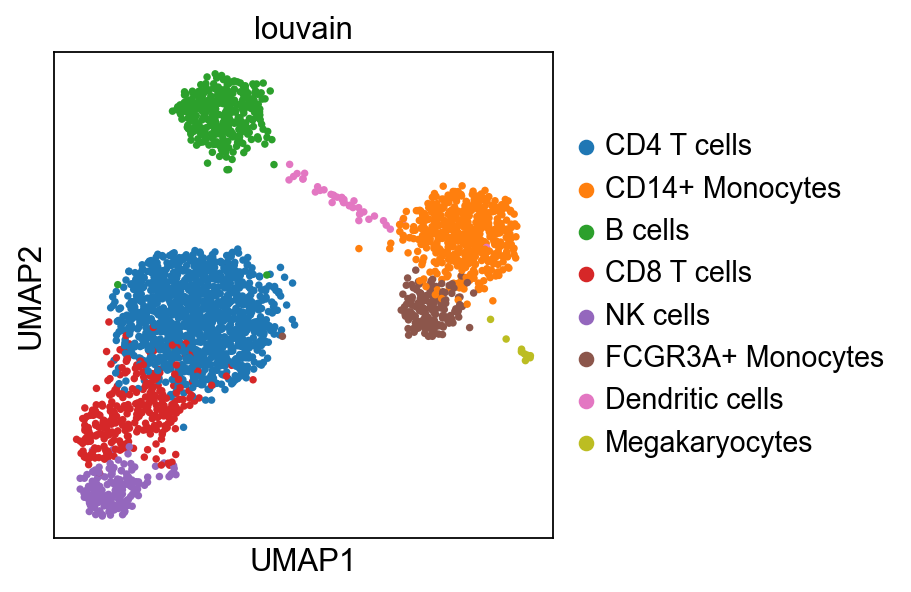

In [11]:
#| label: process-ref
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color='louvain')

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
computing UMAP
    finished (0:00:00)


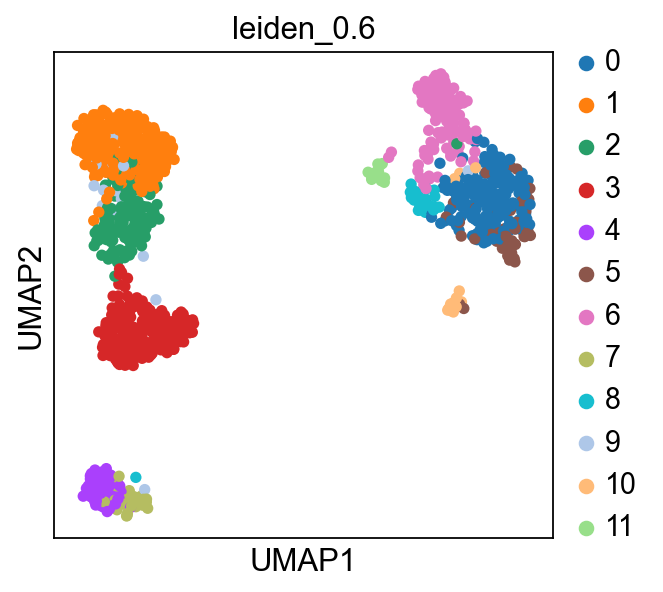

In [12]:
#| label: process-data
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden_0.6')

## Integrate with scanorama

In [13]:
#| label: integrate
import scanorama

#subset the individual dataset to the same variable genes as in MNN-correct.
alldata = dict()
alldata['ctrl']=adata
alldata['ref']=adata_ref

#convert to list of AnnData objects
adatas = list(alldata.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 1676 genes among all datasets
[[0.         0.43067591]
 [0.         0.        ]]
Processing datasets (0, 1)


In [14]:
#| label: scanorama-results
# add in sample info
adata_ref.obs['sample']='pbmc3k'

# create a merged scanpy object and add in the scanorama 
adata_merged = alldata['ctrl'].concatenate(alldata['ref'], batch_key='sample', batch_categories=['ctrl','pbmc3k'])

embedding = np.concatenate([ad.obsm['X_scanorama'] for ad in adatas], axis=0)
adata_merged.obsm['Scanorama'] = embedding

In [15]:
#| label: process-scanorama
#run  umap.
sc.pp.neighbors(adata_merged, n_pcs =50, use_rep = "Scanorama")
sc.tl.umap(adata_merged)

computing neighbors
    finished (0:00:00)
computing UMAP
    finished (0:00:02)


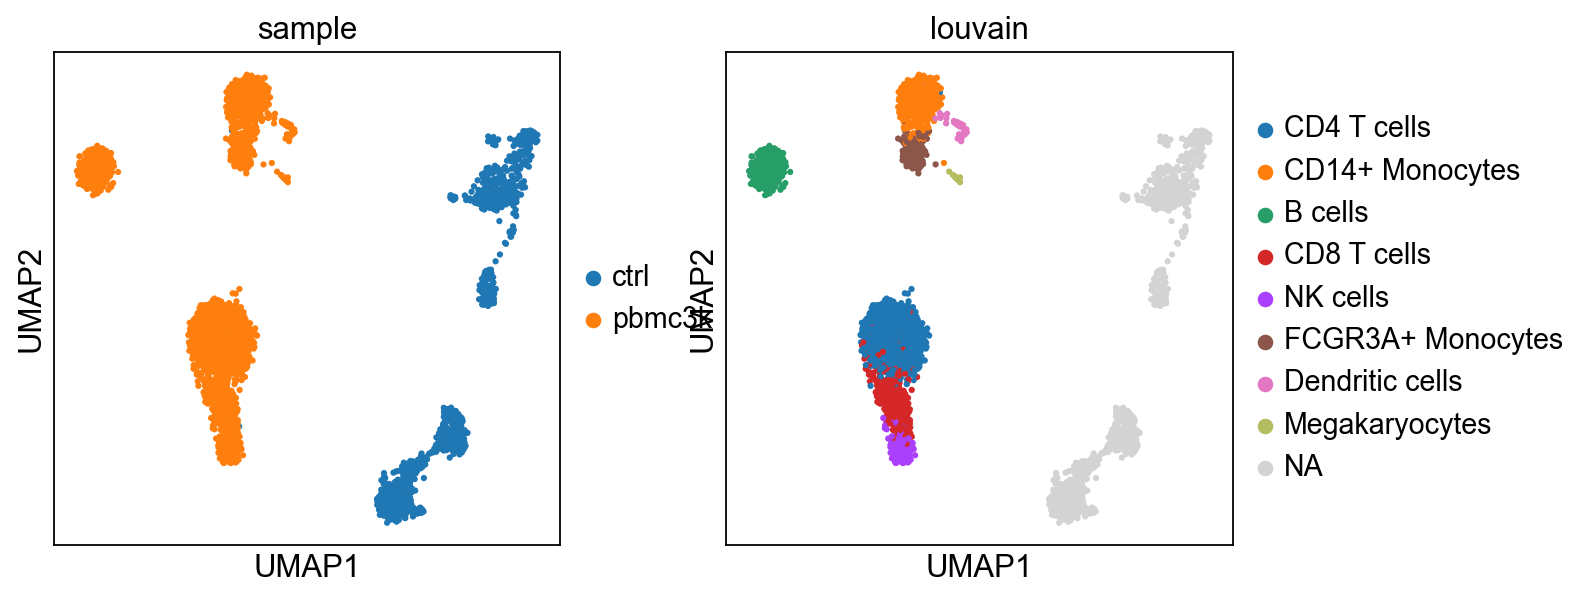

In [16]:
#| label: plot-scanorama
sc.pl.umap(adata_merged, color=["sample","louvain"])

### Label transfer

Using the functions from the [Spatial
tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/spatial/integration-scanorama.html)
from Scanpy we will calculate normalized cosine distances between the
two datasets and tranfer labels to the celltype with the highest scores.

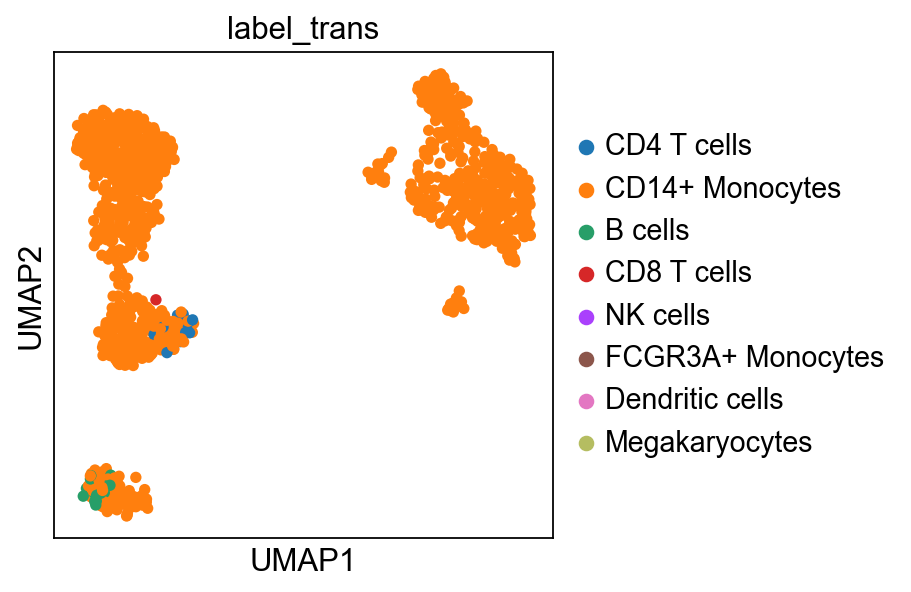

In [17]:
#| label: transfer
from sklearn.metrics.pairwise import cosine_distances

distances = 1 - cosine_distances(
    adata_merged[adata_merged.obs['sample'] == "pbmc3k"].obsm["Scanorama"],
    adata_merged[adata_merged.obs['sample'] == "ctrl"].obsm["Scanorama"],
)

def label_transfer(dist, labels, index):
    lab = pd.get_dummies(labels)
    class_prob = lab.to_numpy().T @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    # class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    class_prob = (class_prob.T - class_prob.min(1)) / np.ptp(class_prob)
    
    # convert to df
    cp_df = pd.DataFrame(
        class_prob, columns=lab.columns
    )
    cp_df.index = index
    # classify as max score
    m = cp_df.idxmax(axis=1)
    
    return m

class_def = label_transfer(distances, adata_ref.obs.louvain, adata.obs.index)

# add to obs section of the original object
adata.obs['label_trans'] = class_def

sc.pl.umap(adata, color="label_trans")

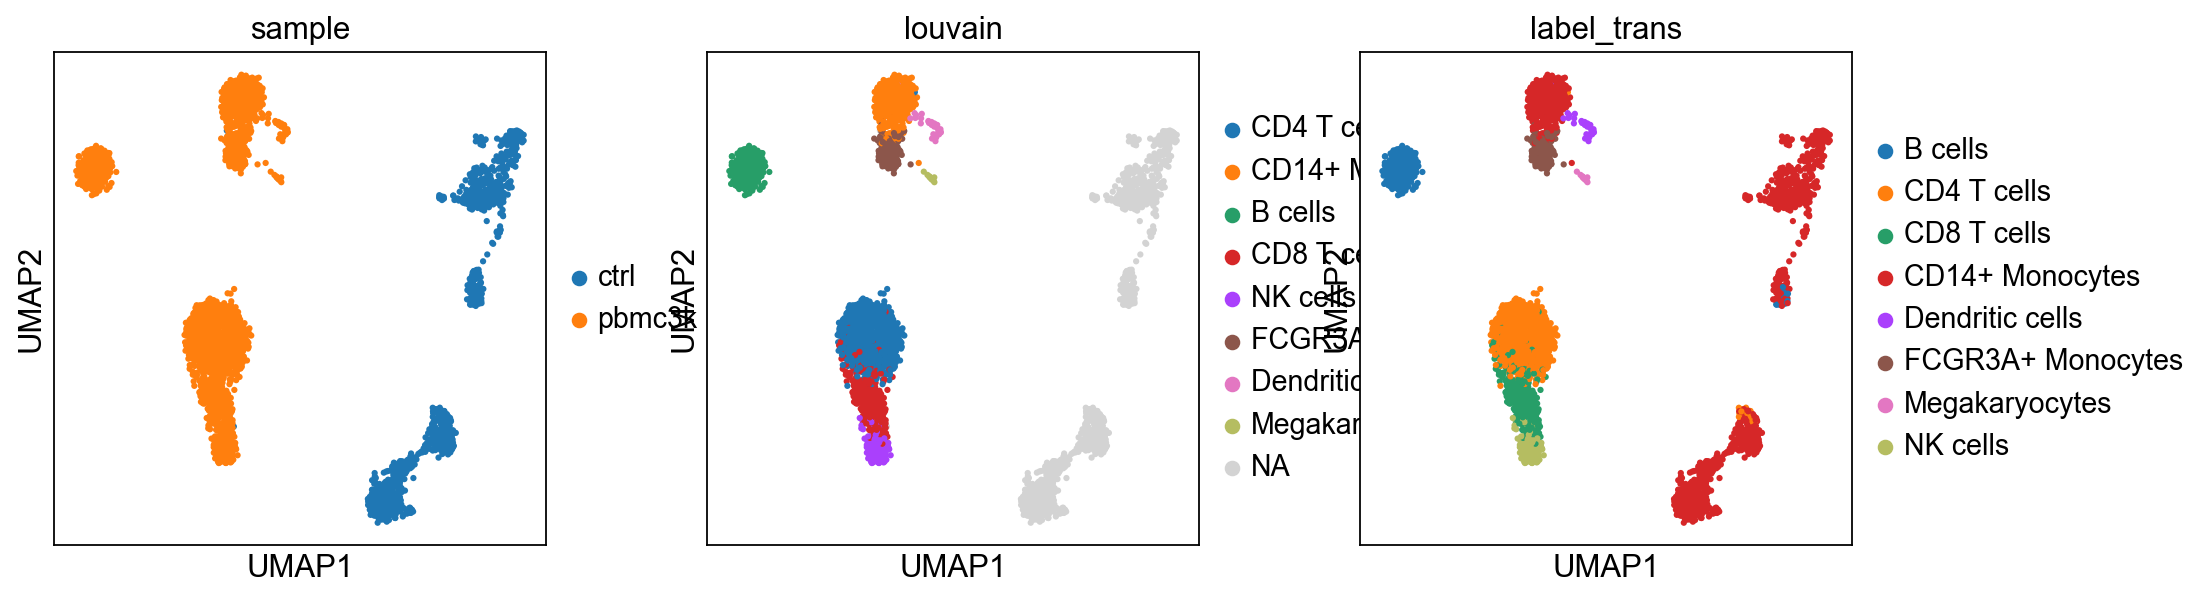

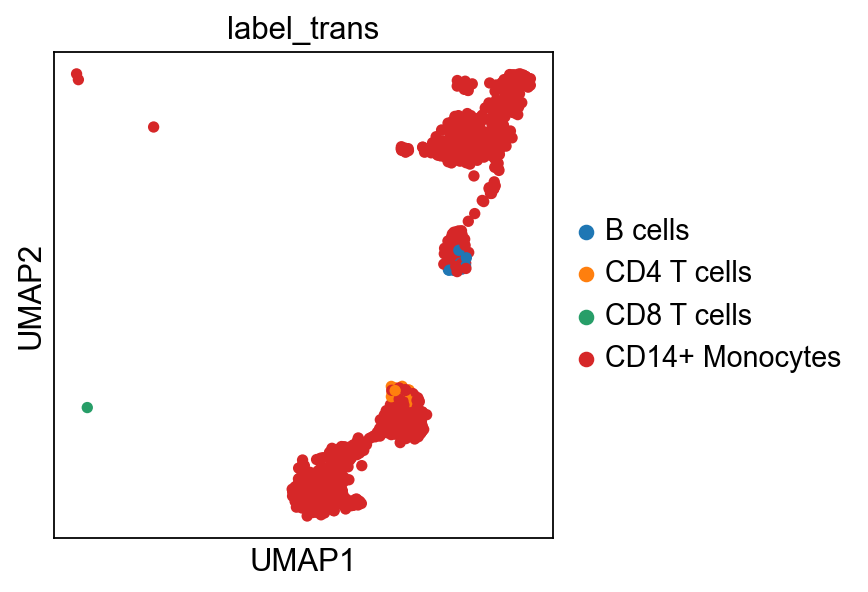

In [18]:
#| label: plot-transfer
# add to merged object.
adata_merged.obs["label_trans"] = pd.concat(
    [class_def, adata_ref.obs["louvain"]], axis=0
).tolist()

sc.pl.umap(adata_merged, color=["sample","louvain",'label_trans'])
#plot only ctrl cells.
sc.pl.umap(adata_merged[adata_merged.obs['sample']=='ctrl'], color='label_trans')

Now plot how many cells of each celltypes can be found in each cluster.

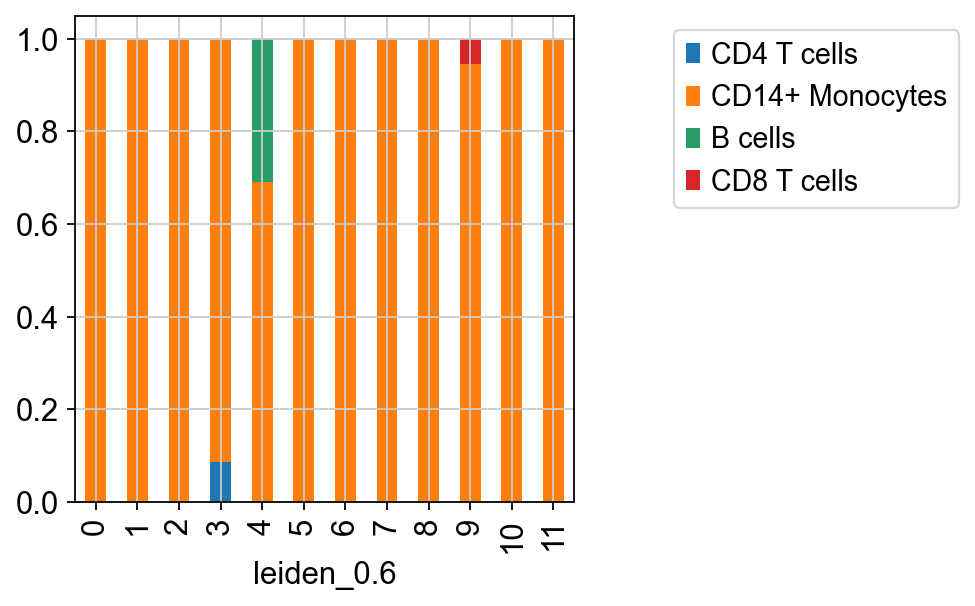

In [19]:
#| label: distributions
tmp = pd.crosstab(adata.obs['leiden_0.6'],adata.obs['label_trans'], normalize='index')
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.8, 1),loc='upper right')

## Ingest

Another method for celltype prediction is Ingest, for more information,
please look at
https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html

running ingest
    finished (0:00:07)


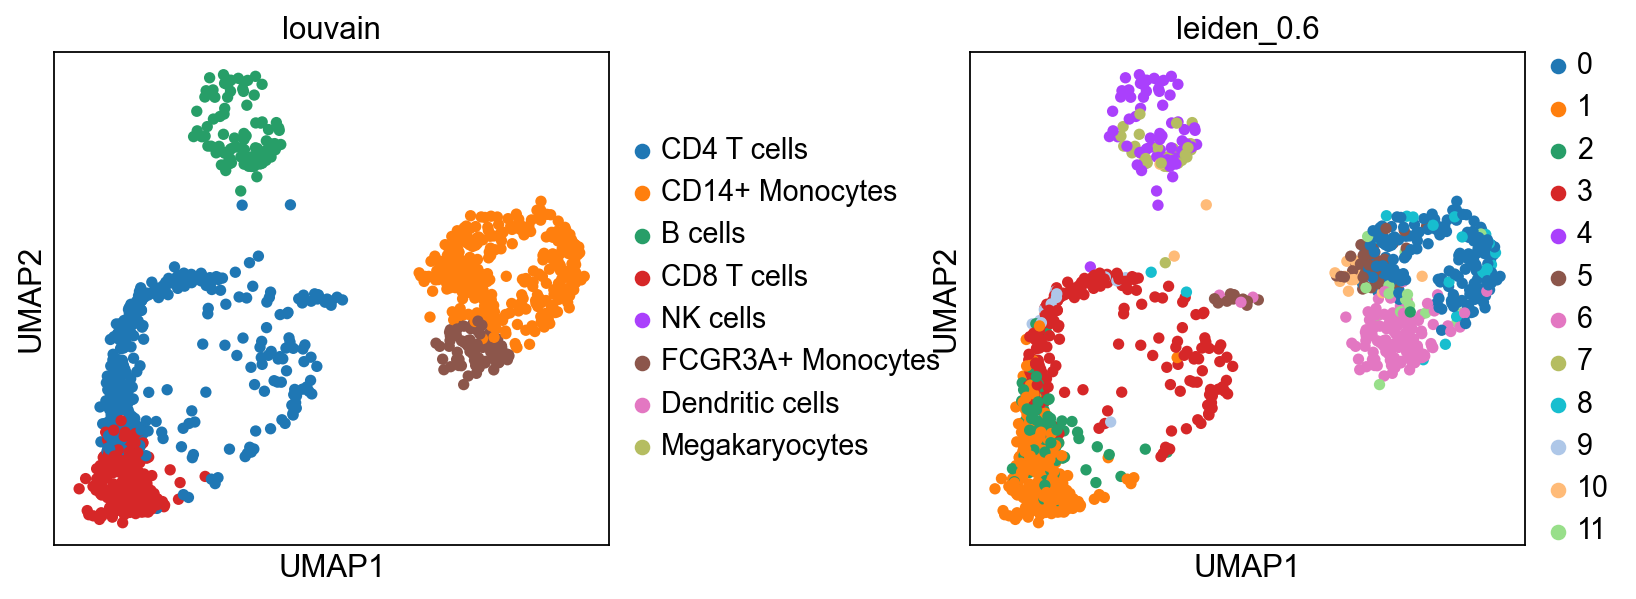

In [20]:
#| label: ingest
sc.tl.ingest(adata, adata_ref, obs='louvain')
sc.pl.umap(adata, color=['louvain','leiden_0.6'], wspace=0.5)

As you can see, ingest has created a new umap for us, so to get
consistent plotting, lets revert back to the old one for further
plotting:

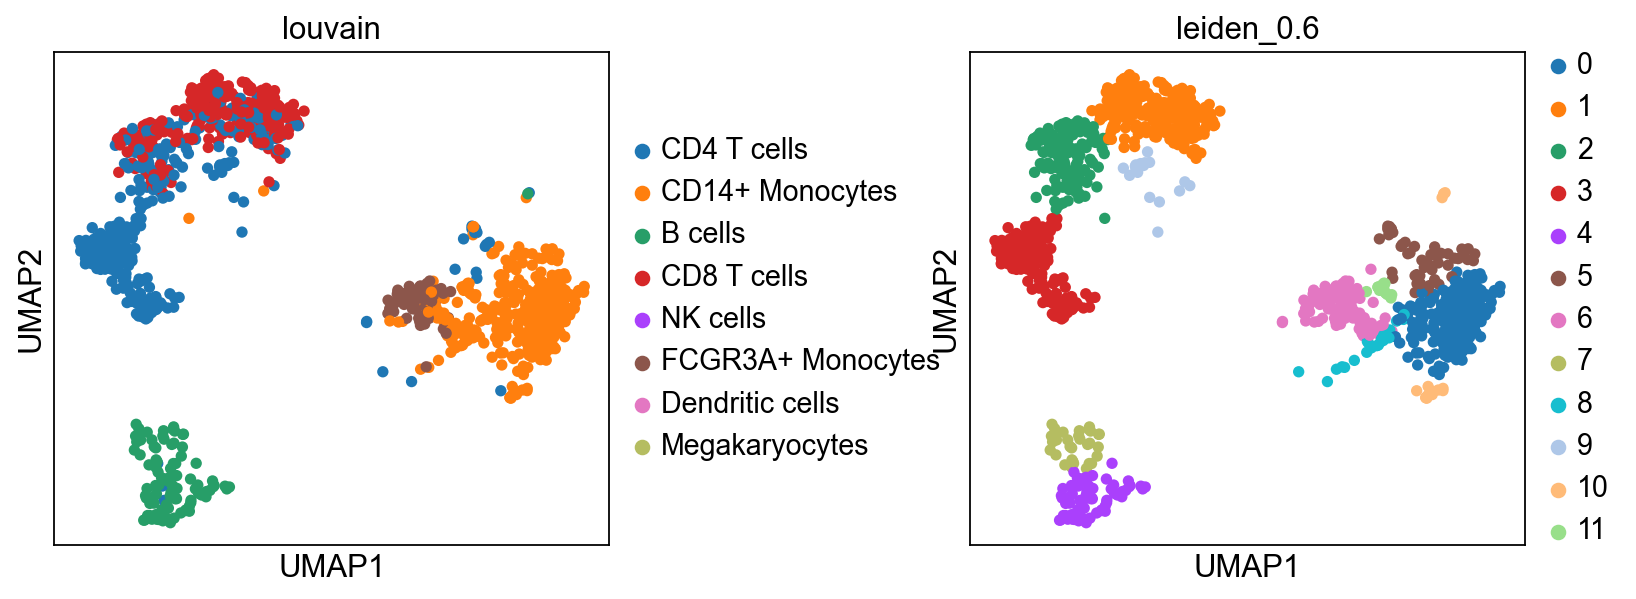

In [21]:
#| label: old-umap
adata.obsm["X_umap"] = adata.obsm["X_umap_uncorr"]

sc.pl.umap(adata, color=['louvain','leiden_0.6'], wspace=0.5)

Now plot how many cells of each celltypes can be found in each cluster.

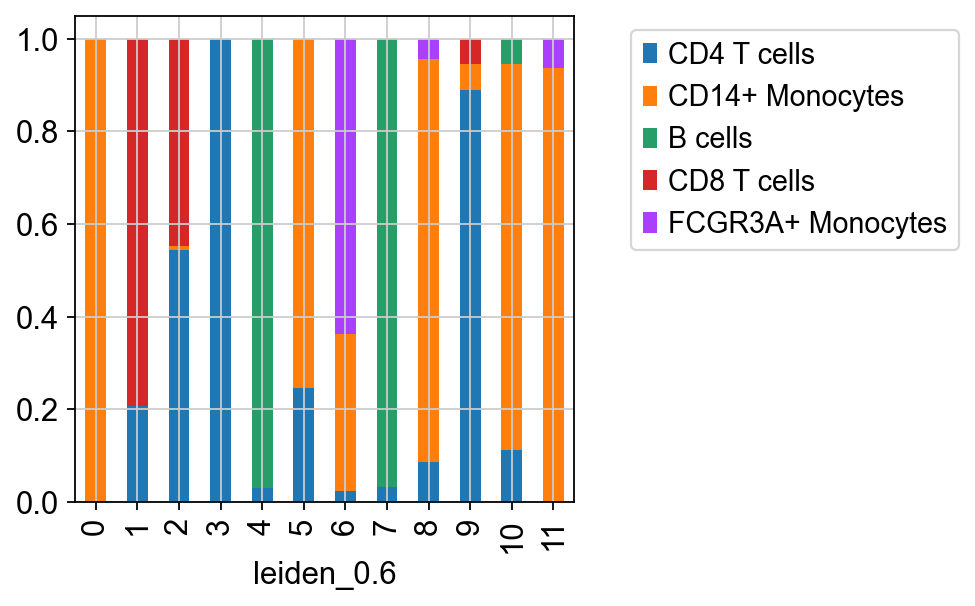

In [22]:
#| label: distributions-ingest
tmp = pd.crosstab(adata.obs['leiden_0.6'],adata.obs['louvain'], normalize='index')
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.8, 1),loc='upper right')

## Celltypist

[Celltypist](https://www.celltypist.org/) provides pretrained models for
classification for many different human tissues and celltypes. Here, we
are following the steps of this
[tutorial](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb),
with some adaptations for this dataset. So please check out the tutorial
for more detail.

In [23]:
#| label: fetch-celltypist
import celltypist
from celltypist import models

# there are many different models, we will only download 2 of them for now.
models.download_models(force_update = False, model = 'Immune_All_Low.pkl')
models.download_models(force_update = False, model = 'Immune_All_High.pkl')

📂 Storing models in /Users/daweihuang/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_Low.pkl (file exists)
📂 Storing models in /Users/daweihuang/.celltypist/data/models
💾 Total models to download: 1
⏩ Skipping [1/1]: Immune_All_High.pkl (file exists)


Now select the model you want to use and show the info:

In [24]:
#| label: celltypist-model
model = models.Model.load(model = 'Immune_All_High.pkl')

model

CellTypist model with 32 cell types and 6639 features
    date: 2022-07-16 08:53:00.959521
    details: immune populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: B cells, B-cell lineage, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

To infer celltype labels to our cells, we first need to convert back to
the full matrix. OBS! For celltypist we want to have log1p normalised
expression to 10,000 counts per cell. Which we already have in
`adata.raw.X`, check by summing up the data, it should sum to 10K.

In [25]:
#| label: from-raw
adata = adata.raw.to_adata() 
adata.X.expm1().sum(axis = 1)[:10]

matrix([[10000.],
        [10000.],
        [10000.],
        [10000.],
        [10000.],
        [10000.],
        [10000.],
        [10000.],
        [10000.],
        [10000.]])

In [26]:
#| label: celltypist
predictions = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

predictions.predicted_labels

🔬 Input data has 1154 cells and 19468 genes
🔗 Matching reference genes in the model
🧬 5460 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


,predicted_labels,over_clustering,majority_voting
AGGTCATGTGCGAACA-13-5,T cells,15,T cells
CCTATCGGTCCCTCAT-13-5,ILC,18,ILC
TCCTCCCTCGTTCATT-13-5,HSC/MPP,23,ILC
CAACCAATCATCTATC-13-5,ILC,18,ILC
TACGGTATCGGATTAC-13-5,T cells,5,T cells
...,...,...,...
TCCACCATCATAGCAC-13-5,T cells,15,T cells
GAGTTACAGTGAGTGC-13-5,T cells,11,T cells
ATCATTCAGGCTCACC-13-5,Monocytes,20,Monocytes
AGCCACGCAACCCTAA-13-5,T cells,0,T cells


The first column `predicted_labels` is the predictions made for each
individual cell, while `majority_voting` is done for local subclusters,
the clustering identities are in column `over_clustering`.

Now we convert the predictions to an anndata object.

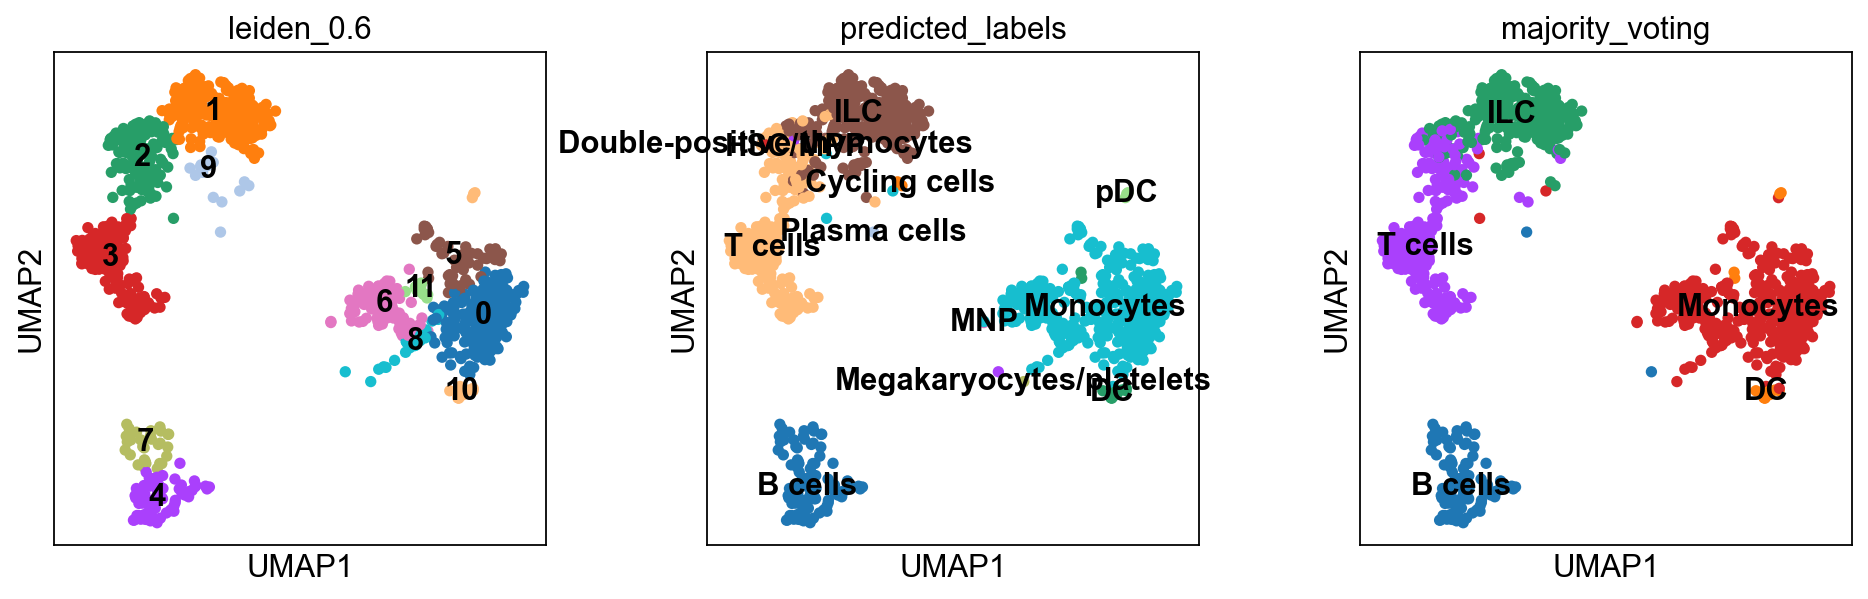

In [27]:
#| label: plot-celltypist
adata = predictions.to_adata()

sc.pl.umap(adata, color = ['leiden_0.6', 'predicted_labels', 'majority_voting'], legend_loc = 'on data')

<div>

> **Task**
>
> Rerun predictions with Celltypist, but use another model, for instance
> `Immune_All_High.pkl`, or any other model you find relevant, you can
> find a list of models [here](https://www.celltypist.org/models). How
> do the results differ for you?

</div>

### Celltypist custom model

We can also train our own model on any reference data that we want to
use. In this case we will use the pbmc data in `adata_ref` to train a
model.

Celltypist requires the data to be in the format of log1p normalised
expression to 10,000 counts per cell, we can check if that is the case
for the object we have:

In [28]:
#| label: prep-refdata
adata_ref.raw.X.expm1().sum(axis = 1)[:10]

matrix([[2419.],
        [4903.],
        [3147.],
        [2639.],
        [ 980.],
        [2163.],
        [2175.],
        [2260.],
        [1275.],
        [1103.]], dtype=float32)

These should all sum up to 10K, which is not the case, probably since
some genes were removed after normalizing. Wo we will have to start from
the raw counts of that dataset instead. Before we selected the data
`pbmc3k_processed`, but now we will instead use `pbmc3k`.

In [29]:
#| label: prep-refdata2
adata_ref2 = sc.datasets.pbmc3k() 
adata_ref2

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

This data is not annotated, so we will have to match the indices from
the filtered and processed object. And add in the metadata with
annotations.

In [30]:
#| label: prep-refdata3
adata_ref2 = adata_ref2[adata_ref.obs_names,:]
adata_ref2.obs = adata_ref.obs
adata_ref2

AnnData object with n_obs × n_vars = 2638 × 32738
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'sample'
    var: 'gene_ids'

Now we can normalize the matrix:

In [31]:
#| label: process-refdata
sc.pp.normalize_total(adata_ref2, target_sum = 1e4)
sc.pp.log1p(adata_ref2)

# check the sums again
adata_ref2.X.expm1().sum(axis = 1)[:10]

normalizing counts per cell
    finished (0:00:00)


matrix([[10000.   ],
        [ 9999.999],
        [10000.   ],
        [ 9999.998],
        [ 9999.998],
        [10000.   ],
        [ 9999.999],
        [10000.   ],
        [10000.001],
        [10000.   ]], dtype=float32)

And finally train the model.

In [32]:
#| label: celltypist-train
new_model = celltypist.train(adata_ref2, labels = 'louvain', n_jobs = 10, feature_selection = True)

🍳 Preparing data before training
✂️ 16159 non-expressed genes are filtered out
🔬 Input data has 2638 cells and 16579 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 2047 features are selected
🏋️ Starting the second round of training
🏋️ Training data using logistic regression
/opt/anaconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:165: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:165: 

Now we can run predictions on our data

In [33]:
#| label: celltypist-pred
predictions2 = celltypist.annotate(adata, model = new_model, majority_voting = True)

🔬 Input data has 1154 cells and 19468 genes
🔗 Matching reference genes in the model
🧬 1843 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 5


running Leiden clustering
    finished (0:00:00)


🗳️ Majority voting the predictions
✅ Majority voting done!


Instead of converting the predictions to anndata we will just add
another column in the `adata.obs` with these new predictions since the
column names from the previous celltypist runs with clash.

In [34]:
#| label: celltypist-save
adata.obs["predicted_labels_ref"] = predictions2.predicted_labels["predicted_labels"]
adata.obs["majority_voting_ref"] = predictions2.predicted_labels["majority_voting"]

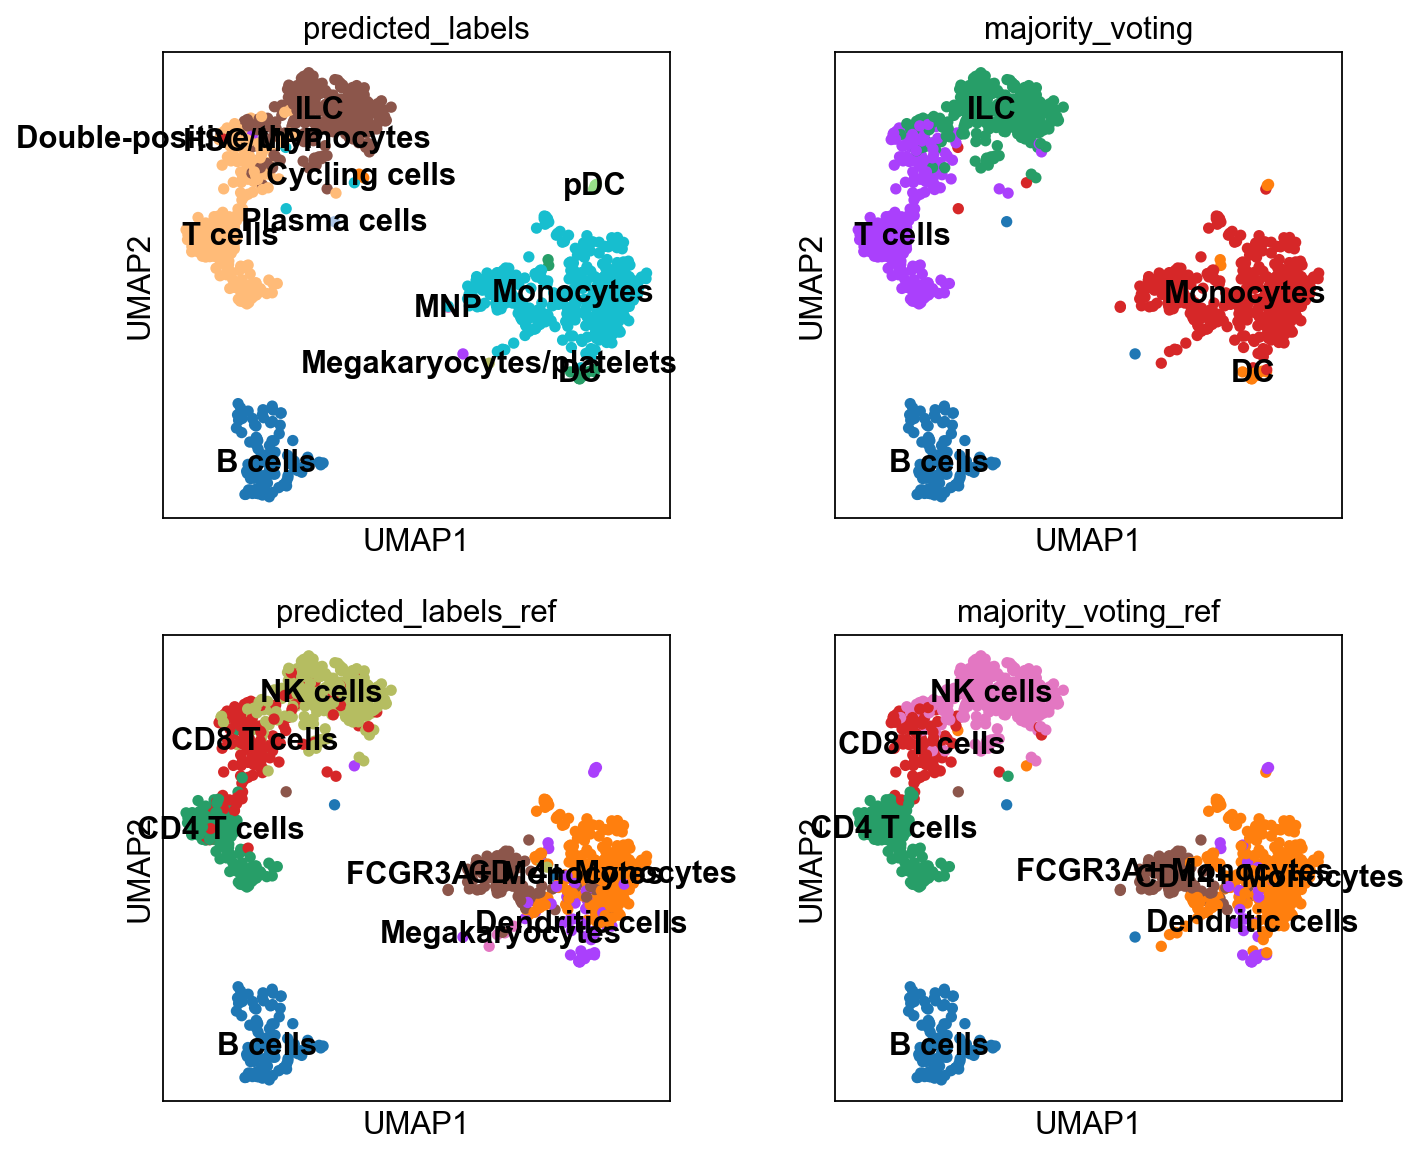

In [35]:
#| label: celltypist-plot
sc.pl.umap(adata, color = ['predicted_labels', 'majority_voting','predicted_labels_ref', 'majority_voting_ref'], legend_loc = 'on data', ncols=2)

## Compare results

The predictions from ingest is stored in the column 'louvain' while we
named the label transfer with scanorama as 'predicted'

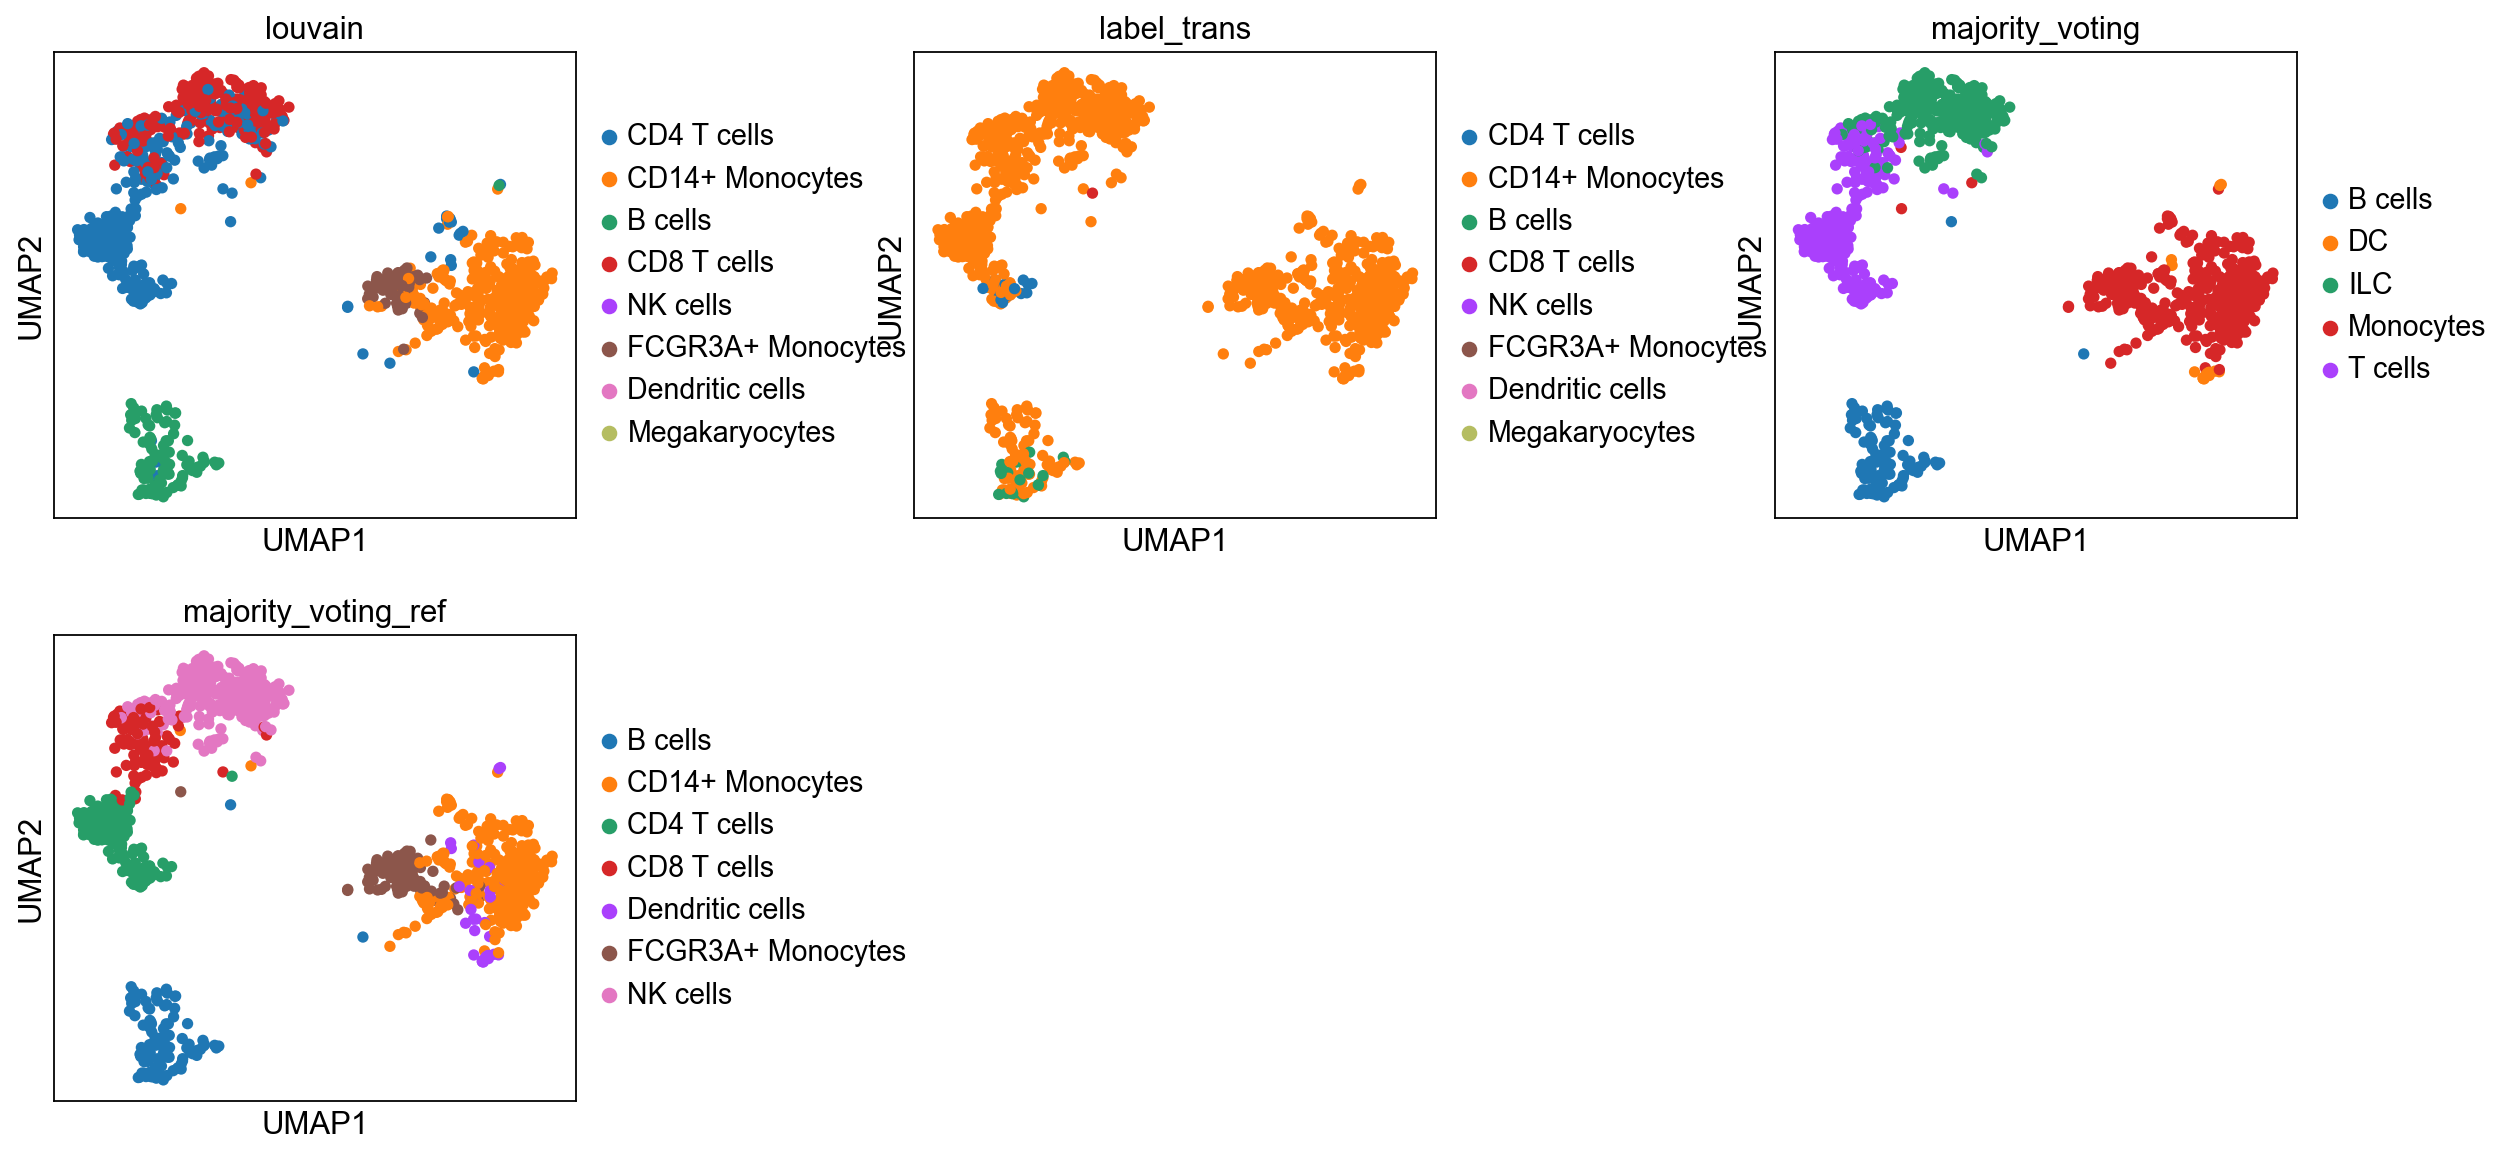

In [36]:
#| label: plot-all
sc.pl.umap(adata, color=['louvain','label_trans','majority_voting', 'majority_voting_ref'], wspace=0.5, ncols=3)

As you can see, the main celltypes are generally the same, but there are
clearly differences, especially with regards to the cells predicted as
either ILC/NK/CD8 T-cells.

The only way to make sure which method you trust is to look at what
genes the different celltypes express and use your biological knowledge
to make decisions.

## Gene set analysis

Another way of predicting celltypes is to use the differentially
expressed genes per cluster and compare to lists of known cell marker
genes. This requires a list of genes that you trust and that is relevant
for the tissue you are working on.

You can either run it with a marker list from the ontology or a list of
your choice as in the example below.

In [37]:
#| label: fetch-markers
path_file = 'data/human_cell_markers.txt'
if not os.path.exists(path_file):
    file_url = os.path.join(path_data, "misc/human_cell_markers.txt")
    subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1416k  100 1416k    0     0   484k      0  0:00:02  0:00:02 --:--:--  484k


In [38]:
#| label: read-markers
df = pd.read_table(path_file)
df

print(df.shape)

(2868, 15)


In [39]:
#| label: prep-markers
# Filter for number of genes per celltype
df['nG'] = df.geneSymbol.str.split(",").str.len()

df = df[df['nG'] > 5]
df = df[df['nG'] < 100]
d = df[df['cancerType'] == "Normal"]
print(df.shape)

# convert to dict.
df.index = df.cellName
gene_dict = df.geneSymbol.str.split(",").to_dict()

(445, 16)


In [40]:
#| label: dge
# run differential expression per cluster
sc.tl.rank_genes_groups(adata, 'leiden_0.6', method='wilcoxon', key_added = "wilcoxon")

ranking genes
    finished (0:00:00)


In [41]:
#| label: gsea
# do gene set overlap to the groups in the gene list and top 300 DEGs.
import gseapy

gsea_res = dict()
pred = dict()

for cl in adata.obs['leiden_0.6'].cat.categories.tolist():
    print(cl)
    glist = sc.get.rank_genes_groups_df(adata, group=cl, key='wilcoxon')[
        'names'].squeeze().str.strip().tolist()
    enr_res = gseapy.enrichr(gene_list=glist[:300],
                             organism='Human',
                             gene_sets=gene_dict,
                             background=adata.shape[1],
                             cutoff=1)
    if enr_res.results.shape[0] == 0:
        pred[cl] = "Unass"
    else:
        enr_res.results.sort_values(
            by="P-value", axis=0, ascending=True, inplace=True)
        print(enr_res.results.head(2))
        gsea_res[cl] = enr_res
        pred[cl] = enr_res.results["Term"][0]

0


TypeError: 'int' object is not iterable

In [42]:
#| label: gsea-res
# prediction per cluster
pred

{}

In [43]:
#| label: plot-gsea
prediction = [pred[x] for x in adata.obs['leiden_0.6']]
adata.obs["GS_overlap_pred"] = prediction

sc.pl.umap(adata, color='GS_overlap_pred')

KeyError: '3'

<div>

> **Discuss**
>
> As you can see, it agrees to some extent with the predictions from the
> methods above, but there are clear differences, which do you think
> looks better?

</div>

## Save data

We can finally save the object for use in future steps.

In [ ]:
#| label: save
adata.write_h5ad('data/covid/results/scanpy_covid_qc_dr_int_cl_ct-ctrl13.h5ad')

## Session info

```{=html}
<details>
```
```{=html}
<summary>
```
Click here
```{=html}
</summary>
```

In [44]:
#| label: session
sc.logging.print_versions()

Package,Version
numpy,2.2.5
anndata,0.11.4
pandas,2.2.3
scanpy,1.11.1
matplotlib,3.10.3
scanorama,1.7.4
scikit-learn,1.5.2
celltypist,1.6.3
gseapy,1.1.8
Component,Info


```{=html}
</details>
```

## archive

In [45]:
!jupyter nbconvert --output-dir archive --to markdown --no-input scanpy_06_celltyping.ipynb

[NbConvertApp] Converting notebook scanpy_06_celltyping.ipynb to markdown
[NbConvertApp] Support files will be in scanpy_06_celltyping_files/
[NbConvertApp] Making directory archive/scanpy_06_celltyping_files
[NbConvertApp] Writing 45810 bytes to archive/scanpy_06_celltyping.md
